In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import shap
import statsmodels.api as sm
from scipy import stats

import src

from dotenv import load_dotenv

from numpy.testing import assert_almost_equal

In [4]:
pd.options.display.float_format = '{:,.2f}'.format
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
filepath = f'..\\..\\{WORK_DIR}\\df_work_test.zip'

df = pd.read_csv(filepath, index_col=0, parse_dates=True)

Проверим размерность датасета

In [6]:
df.shape

(47552, 50)

Время, за которое собраны данные

In [7]:
print(f"В модели используются данные с {df.index.min()} по {df.index.max()}.")

В модели используются данные с 2019-01-01 14:00:00 по 2021-12-31 15:00:00.


Проверим пустые значения

In [8]:
null_check = df.isna().sum()
null_check[null_check > 0]

Series([], dtype: int64)

In [35]:
df.columns

Index(['QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5', 'O2_tot', 'QQ_tot',
       'O2_C1', 'O2_C2', 'O2_C3', 'O2_C4', 'O2_C5', 'AC_level', 'P_H2O',
       'P_O2', 'P_tot', 'P_valve', 'T_abg', 'Fe', 'Stot', 'As', 'Corg', 'Ctot',
       'Fe2+', 'D_S', 'D_SL_H', 'ac', 'Fel_sum', 'C_Solid', 'Q_SL', 'G_Solid',
       'G_Seq', 'G_FeS2', 'G_FeAsS', 'G_O2_st', 'O2_part', 'BettaS_O2_1',
       'BettaS_O2_2', 'BettaS_O2_3', 'BettaS_O2_4', 'BettaS_O2_5', 'QQ_tot_sl',
       'BettaS_QW_1', 'BettaS_QW_2', 'BettaS_QW_3', 'BettaS_QW_4',
       'BettaS_QW_5', 'lag_1', 'lag_2', 'lag_3'],
      dtype='object')

# Анализ данных

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
QQ_C1,"47,552.00",15.15,8.21,0.00,8.88,15.86,20.97,39.86
QQ_C2,"47,552.00",30.42,7.14,0.01,27.52,31.68,34.94,46.08
QQ_C3,"47,552.00",16.92,3.01,0.80,15.69,17.43,18.98,23.01
QQ_C4,"47,552.00",5.37,2.71,0.00,3.14,5.59,7.67,11.43
QQ_C5,"47,552.00",1.39,1.17,0.00,0.48,1.00,2.02,7.77
O2_tot,"47,552.00","5,601.35",766.15,"1,580.51","5,118.18","5,453.59","5,993.91","7,559.17"
QQ_tot,"47,552.00",69.25,14.11,10.74,60.29,70.40,80.23,104.48
O2_C1,"47,552.00","2,141.14",315.75,820.29,"1,915.63","2,117.78","2,323.17","3,100.13"
O2_C2,"47,552.00","1,945.42",270.04,250.01,"1,768.01","1,891.07","2,126.39","2,705.14"
O2_C3,"47,552.00",982.12,166.70,115.74,882.56,960.87,"1,072.01","1,598.46"


## Концентарция $Fe^{2+}$

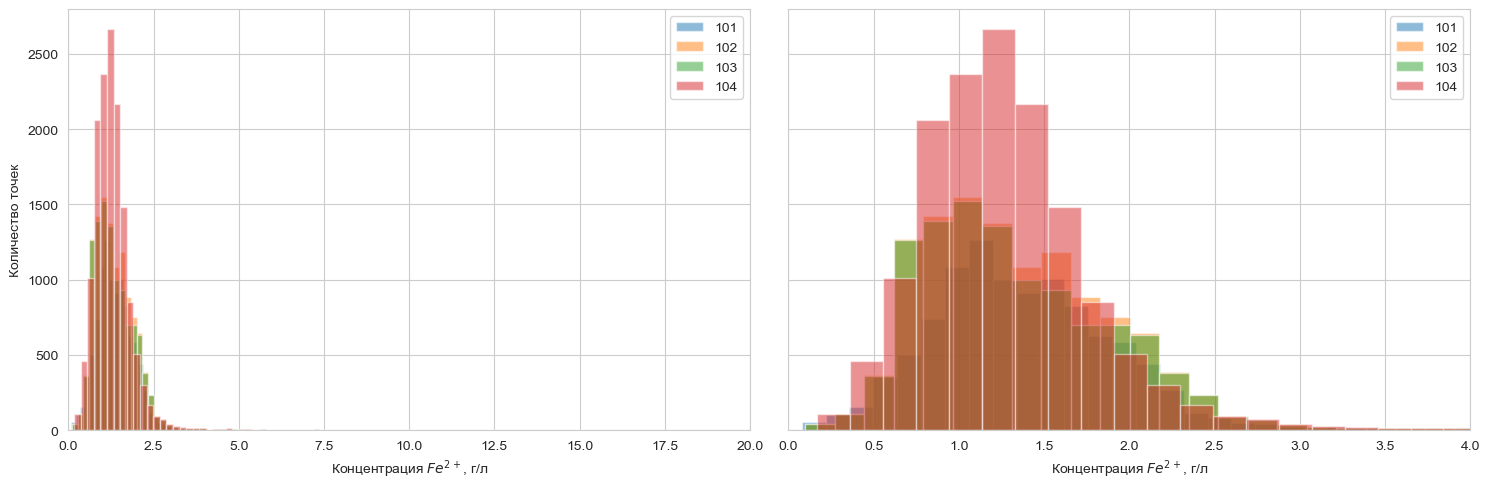

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for ac in [101, 102, 103, 104]:
    ax[0].hist(df.loc[df['ac'] == ac, ['Fe2+']], bins=100, alpha=0.5, label=ac)
    ax[1].hist(df.loc[df['ac'] == ac, ['Fe2+']], bins=100, alpha=0.5, label=ac)

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("Концентрация $Fe^{2+}$, г/л")
ax[1].set_xlabel("Концентрация $Fe^{2+}$, г/л")
ax[0].set_ylabel("Количество точек")

ax[1].set_xlim([0, 4])
ax[0].set_xlim([0, 20])

fig.tight_layout()
plt.show();

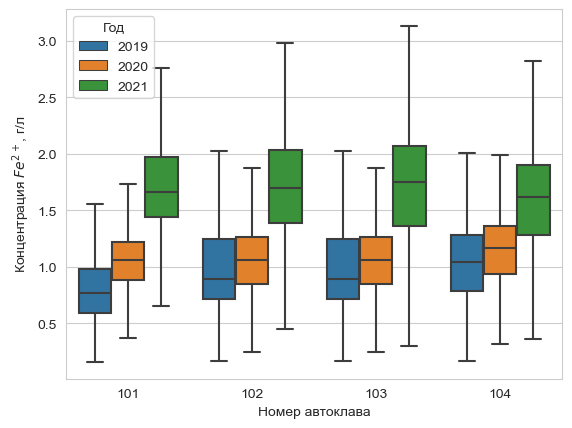

In [11]:
ax = sns.boxplot(data=df, y='Fe2+', x='ac', hue=df.index.year, whis=1.5, showfliers=False)

ax.set_ylabel("Концентрация $Fe^{2+}$, г/л")
ax.set_xlabel("Номер автоклава")

plt.legend(title="Год")

plt.show();

## Анализ химического состава исходных концентратов

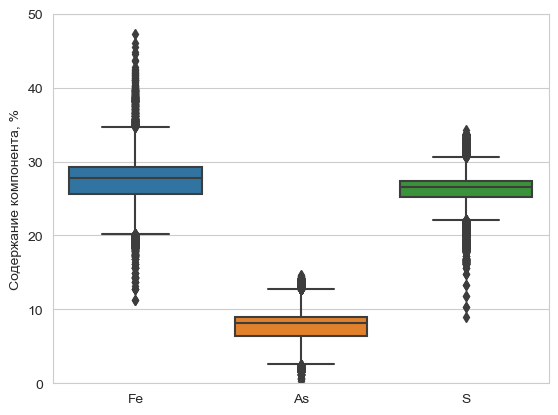

In [12]:
ax = sns.boxplot(data=df[['Fe', 'As', 'Stot']])
ax.set_ylim([0, 50])

ax.set_ylabel("Содержание компонента, %")
ax.set_xticklabels(['Fe', 'As', 'S'])

plt.show();

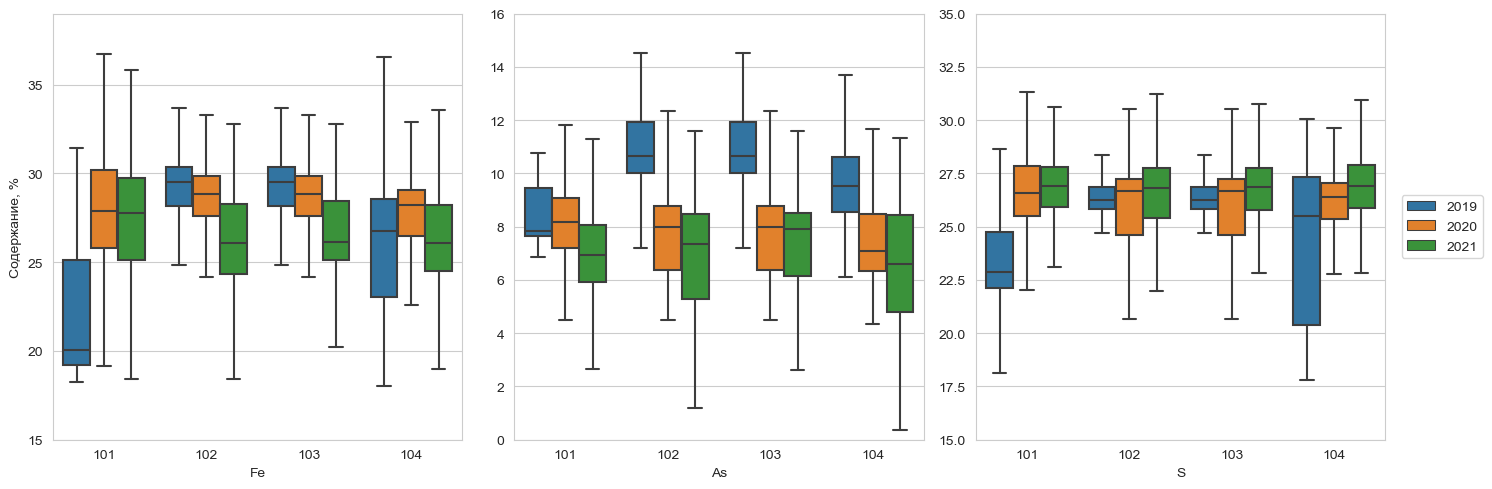

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, y='Fe', x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=axs[0])
sns.boxplot(data=df, y='As', x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=axs[1])
sns.boxplot(data=df, y='Stot', x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=axs[2])

for ax in axs:
    ax.legend([],[], frameon=False)
    ax.set_ylabel("")

axs[0].set_ylabel("Содержание, %")
axs[2].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

axs[0].set_ylim([15, 39])
axs[1].set_ylim([0, 16])
axs[2].set_ylim([15, 35])

axs[0].set_xlabel('Fe')
axs[1].set_xlabel('As')
axs[2].set_xlabel('S')

fig.tight_layout()
plt.show()

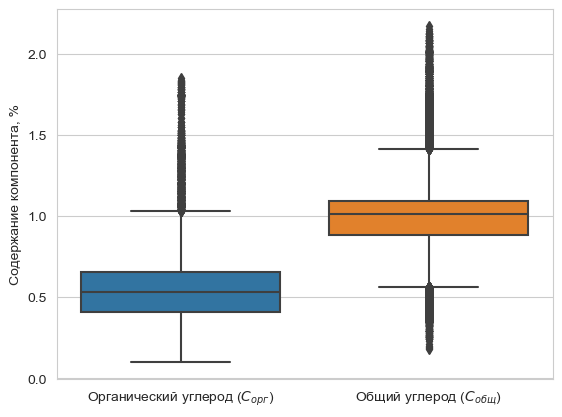

In [14]:
ax = sns.boxplot(data=df[['Corg', 'Ctot']])
ax.set_ylabel("Содержание компонента, %")
ax.set_xticklabels(['Органический углерод ($С_{орг}$)', 'Общий углерод ($С_{общ}$)'])

plt.show();

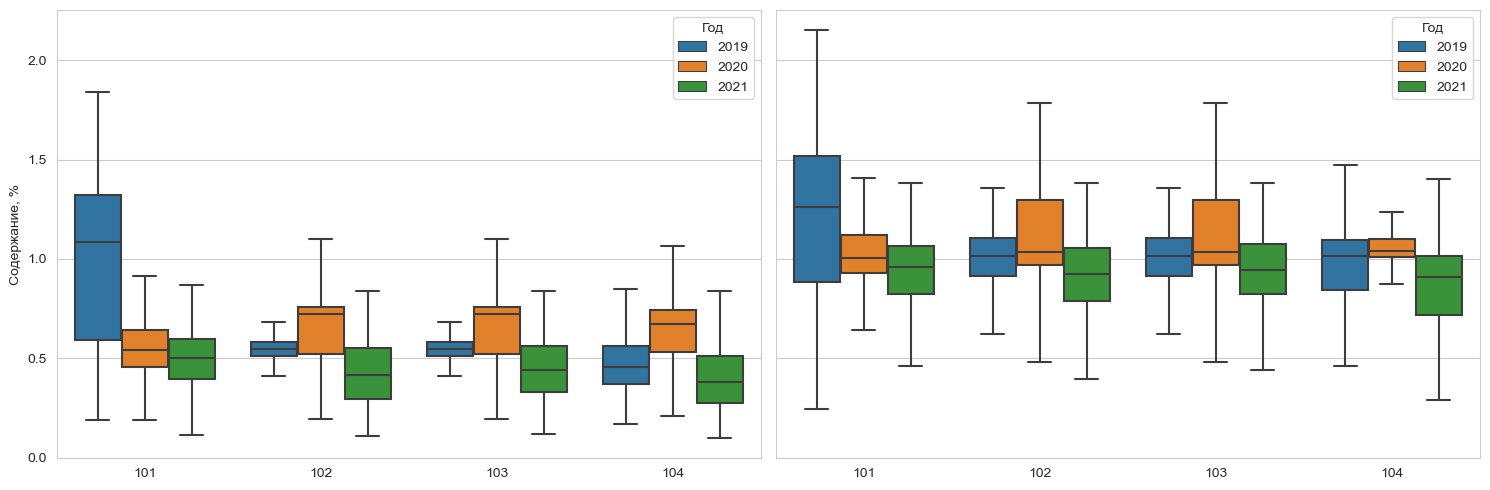

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.boxplot(data=df, y='Corg', x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=ax[0])
sns.boxplot(data=df, y='Ctot', x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=ax[1])

ax[0].legend(title='Год')
ax[1].legend(title='Год')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel("Содержание, %")
ax[1].set_ylabel("")

fig.tight_layout()
plt.show()

## Питающие насосы

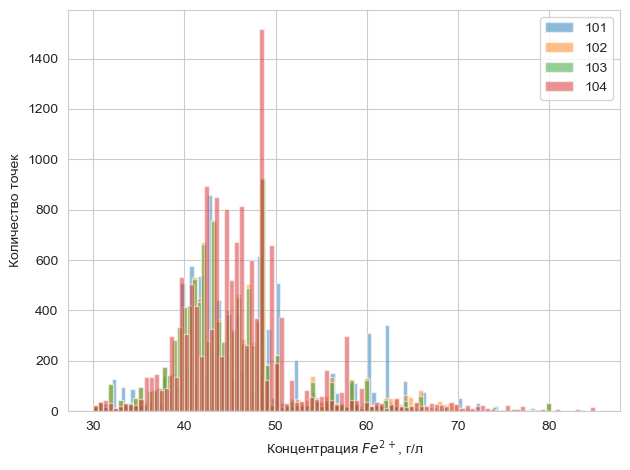

In [16]:
fig, ax = plt.subplots()

for ac in [101, 102, 103, 104]:
    ax.hist(df.loc[df['ac'] == ac, ['Fel_sum']], bins=100, alpha=0.5, label=ac)

ax.legend()

ax.set_xlabel("Концентрация $Fe^{2+}$, г/л")
ax.set_ylabel("Количество точек")

fig.tight_layout()
plt.show();

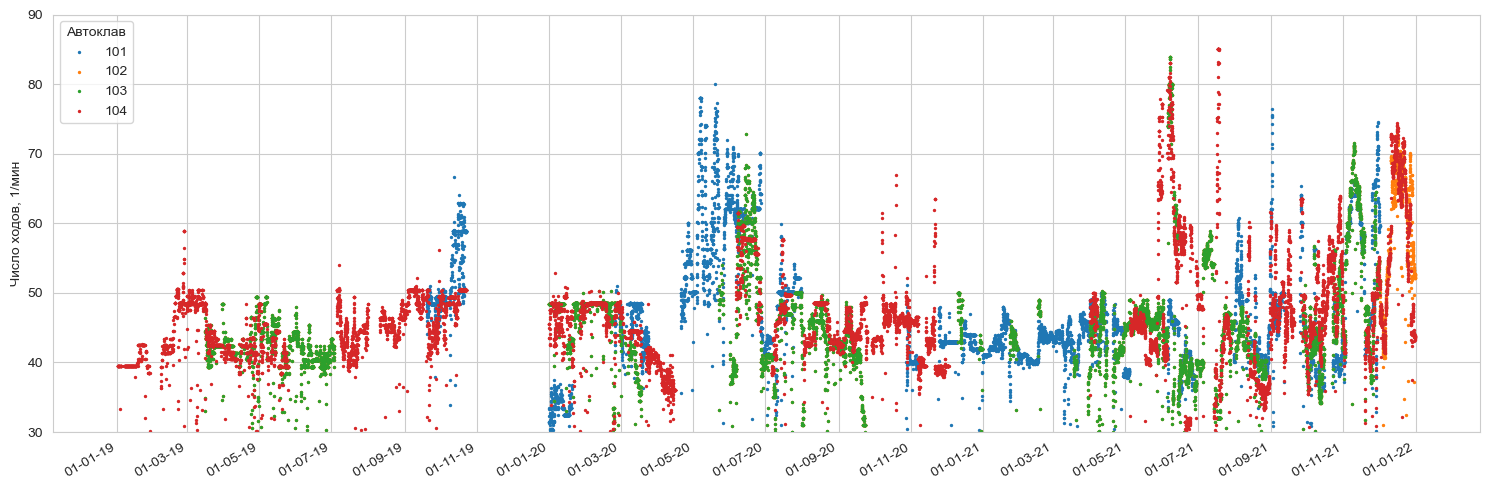

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))

for ac in [101, 102, 103, 104]:
    ax.scatter(x=df.loc[df['ac'] == ac, ['Fel_sum']].index, y=df.loc[df['ac'] == ac, ['Fel_sum']], label=ac, s=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_ylabel("Число ходов, 1/мин")

ax.legend(title='Автоклав', loc="upper left")
fig.autofmt_xdate()

ax.set_ylim([30, 90])

fig.tight_layout()
plt.show();

## Расход воды по секциям автоклавов

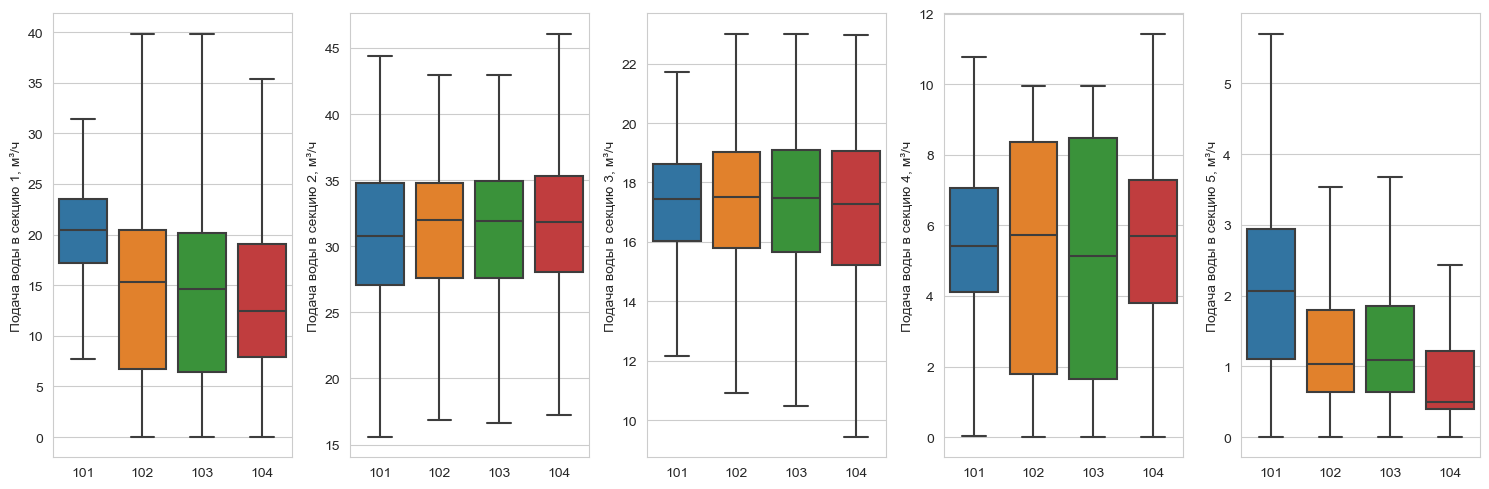

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, comp in enumerate(['QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5']):
    sns.boxplot(data=df, y=comp, x='ac', whis=1.5, showfliers=False, ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_ylabel(f"Подача воды в секцию {i + 1}, м³/ч")

fig.tight_layout()
plt.show();

## Давление и расход кислорода

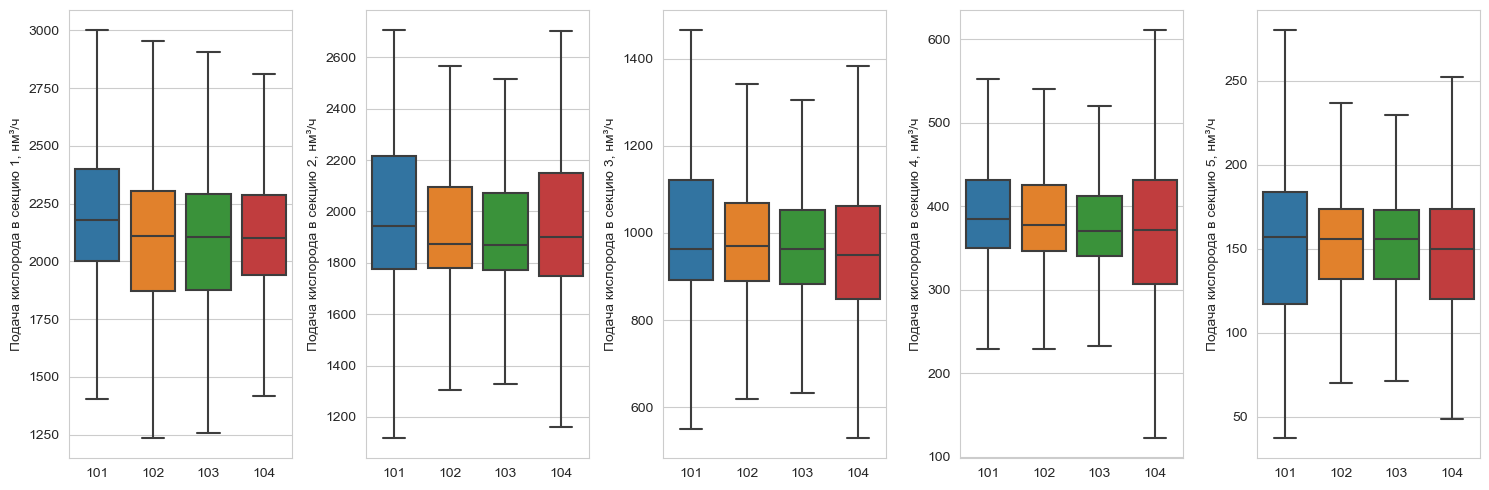

In [49]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, comp in enumerate(['O2_C1', 'O2_C2', 'O2_C3', 'O2_C4', 'O2_C5']):
    sns.boxplot(data=df, y=comp, x='ac', whis=1.5, showfliers=False, ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_ylabel(f"Подача кислорода в секцию {i + 1}, нм³/ч")

fig.tight_layout()
plt.show();

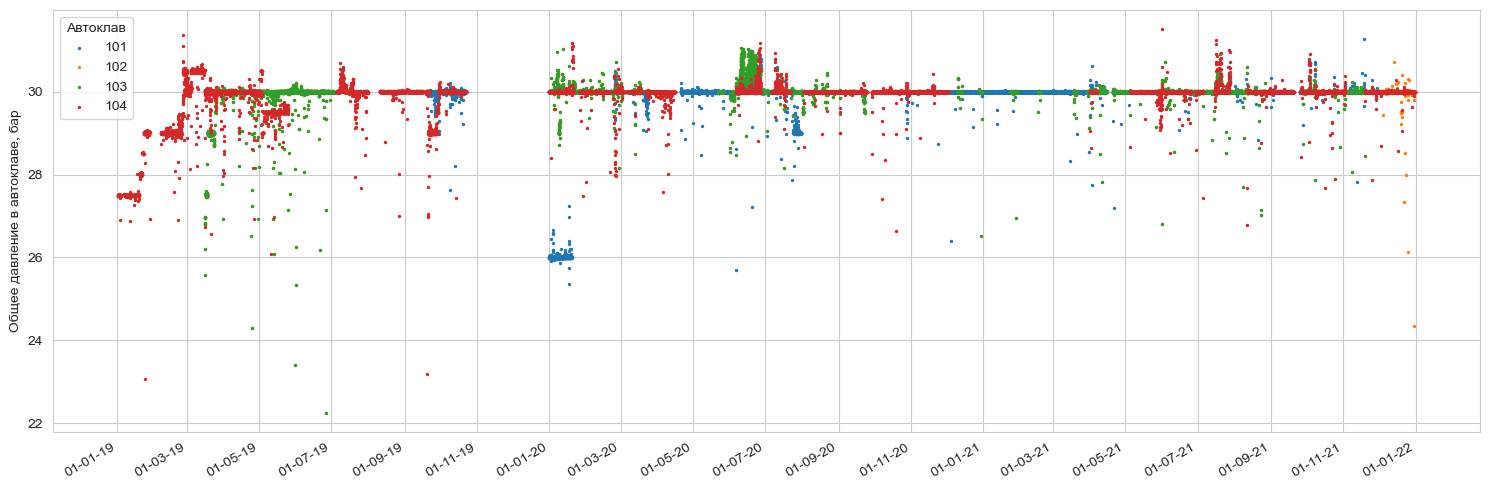

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))

for ac in [101, 102, 103, 104]:
    ax.scatter(x=df.loc[df['ac'] == ac, ['P_tot']].index, y=df.loc[df['ac'] == ac, ['P_tot']], label=ac, s=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_ylabel("Общее давление в автоклаве, бар")

ax.legend(title='Автоклав', loc="upper left")
fig.autofmt_xdate()

fig.tight_layout()
plt.show();

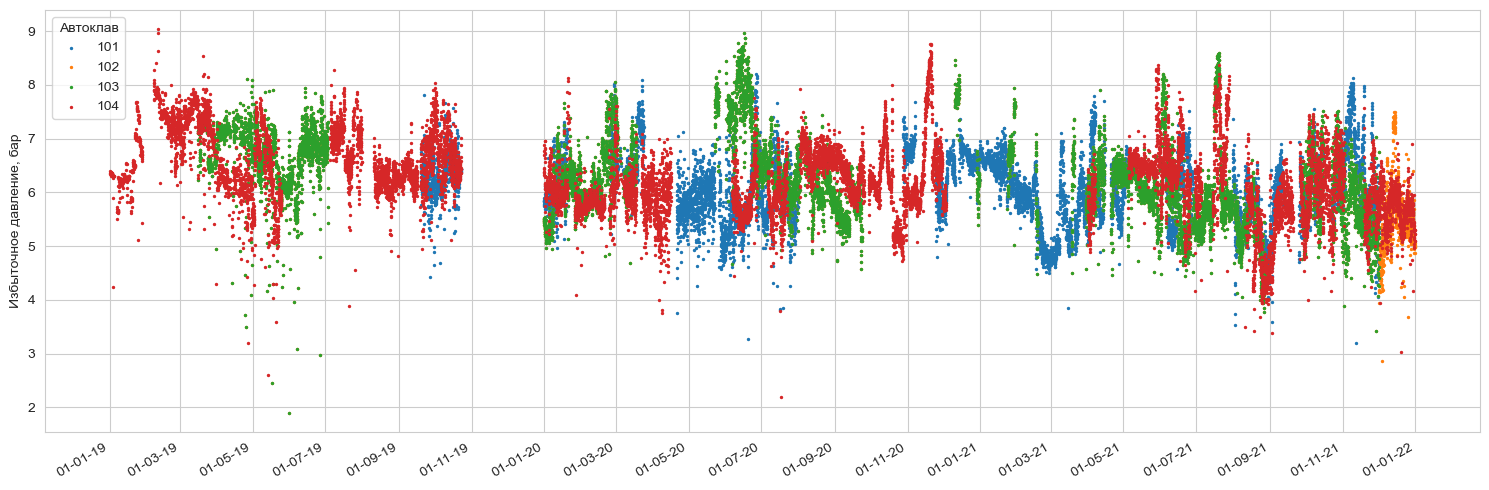

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))

for ac in [101, 102, 103, 104]:
    ax.scatter(x=df.loc[df['ac'] == ac, ['P_O2']].index, y=df.loc[df['ac'] == ac, ['P_O2']], label=ac, s=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_ylabel("Избыточное давление, бар")

ax.legend(title='Автоклав', loc="upper left")
fig.autofmt_xdate()

fig.tight_layout()
plt.show();

## Уровень в автоклавах

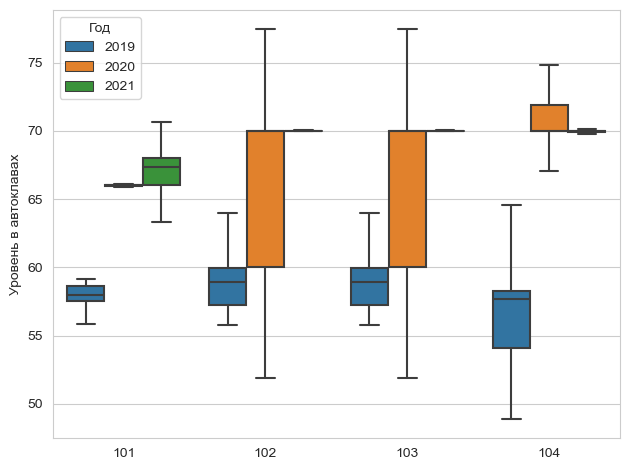

In [60]:
fig, ax = plt.subplots()

sns.boxplot(data=df, y='AC_level', x='ac', hue=df.index.year, whis=1.5, showfliers=False)
ax.set_xlabel("")
ax.set_ylabel(f"Уровень в автоклавах")
ax.legend(title="Год")

fig.tight_layout()
plt.show();

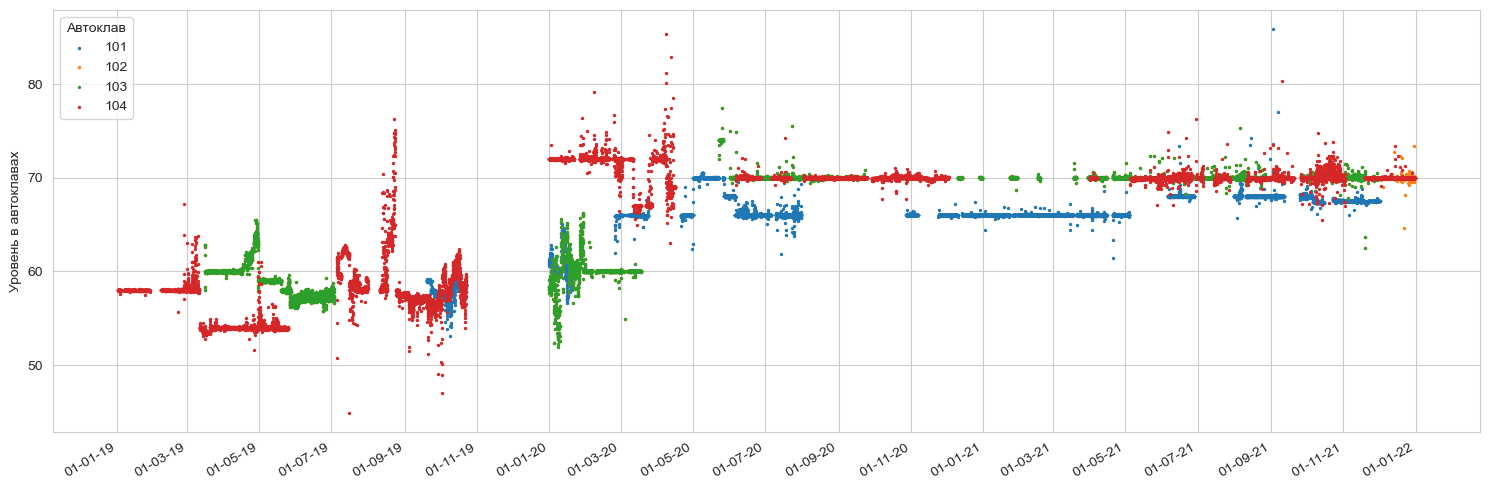

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))

for ac in [101, 102, 103, 104]:
    ax.scatter(x=df.loc[df['ac'] == ac, ['AC_level']].index, y=df.loc[df['ac'] == ac, ['AC_level']], label=ac, s=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_ylabel("Уровень в автоклавах")

ax.legend(title='Автоклав', loc="upper left")
fig.autofmt_xdate()

fig.tight_layout()
plt.show();

## Температура абгаза

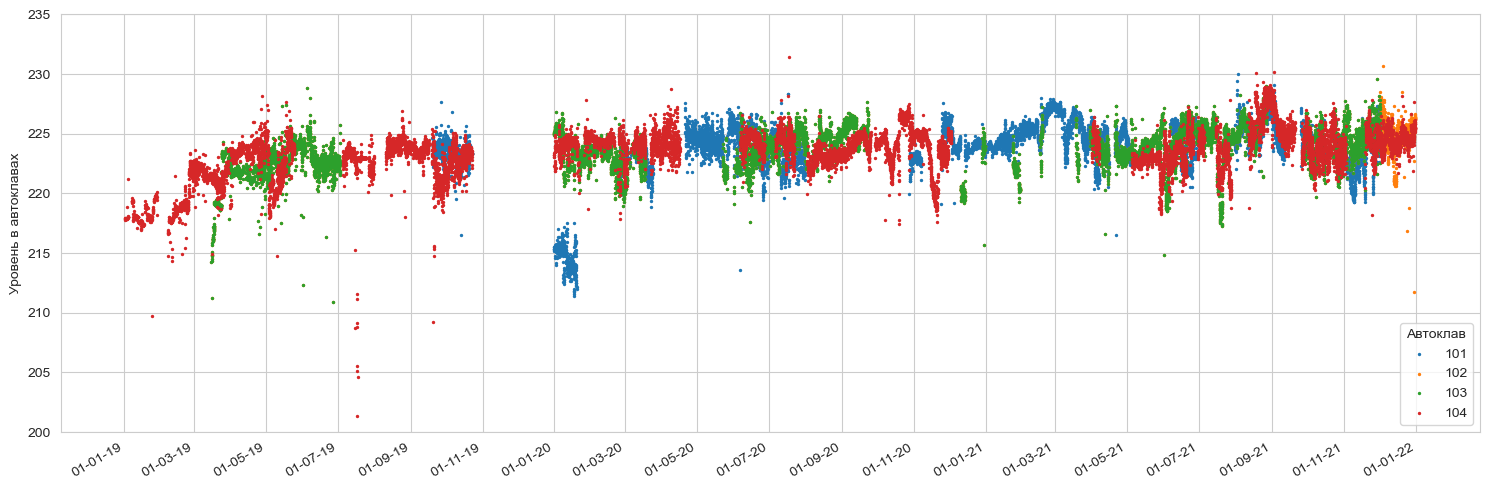

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))

for ac in [101, 102, 103, 104]:
    ax.scatter(x=df.loc[df['ac'] == ac, ['T_abg']].index, y=df.loc[df['ac'] == ac, ['T_abg']], label=ac, s=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_ylabel("Температура абгаза, °С")
ax.set_ylim([200, 235])

ax.legend(title='Автоклав', loc="lower right")
fig.autofmt_xdate()

fig.tight_layout()
plt.show();

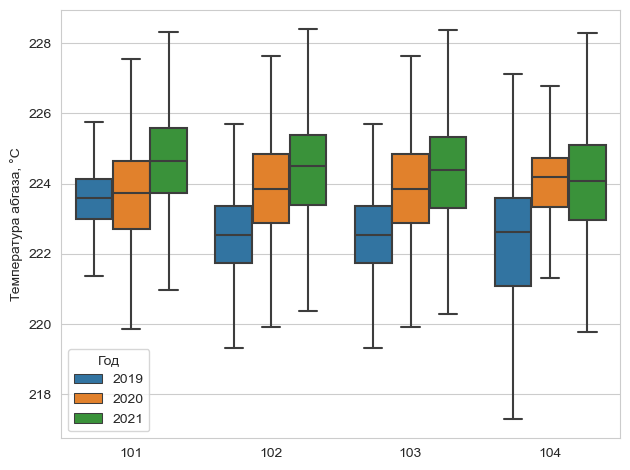

In [70]:
fig, ax = plt.subplots()

sns.boxplot(data=df, y='T_abg', x='ac', hue=df.index.year, whis=1.5, showfliers=False)
ax.set_xlabel("")
ax.set_ylabel("Температура абгаза, °С")
ax.legend(title="Год")

fig.tight_layout()
plt.show();

## Степень окисления

'BettaS_O2_1', 'BettaS_O2_2', 'BettaS_O2_3', 'BettaS_O2_4', 'BettaS_O2_5'
'BettaS_QW_1', 'BettaS_QW_2', 'BettaS_QW_3', 'BettaS_QW_4', 'BettaS_QW_5'

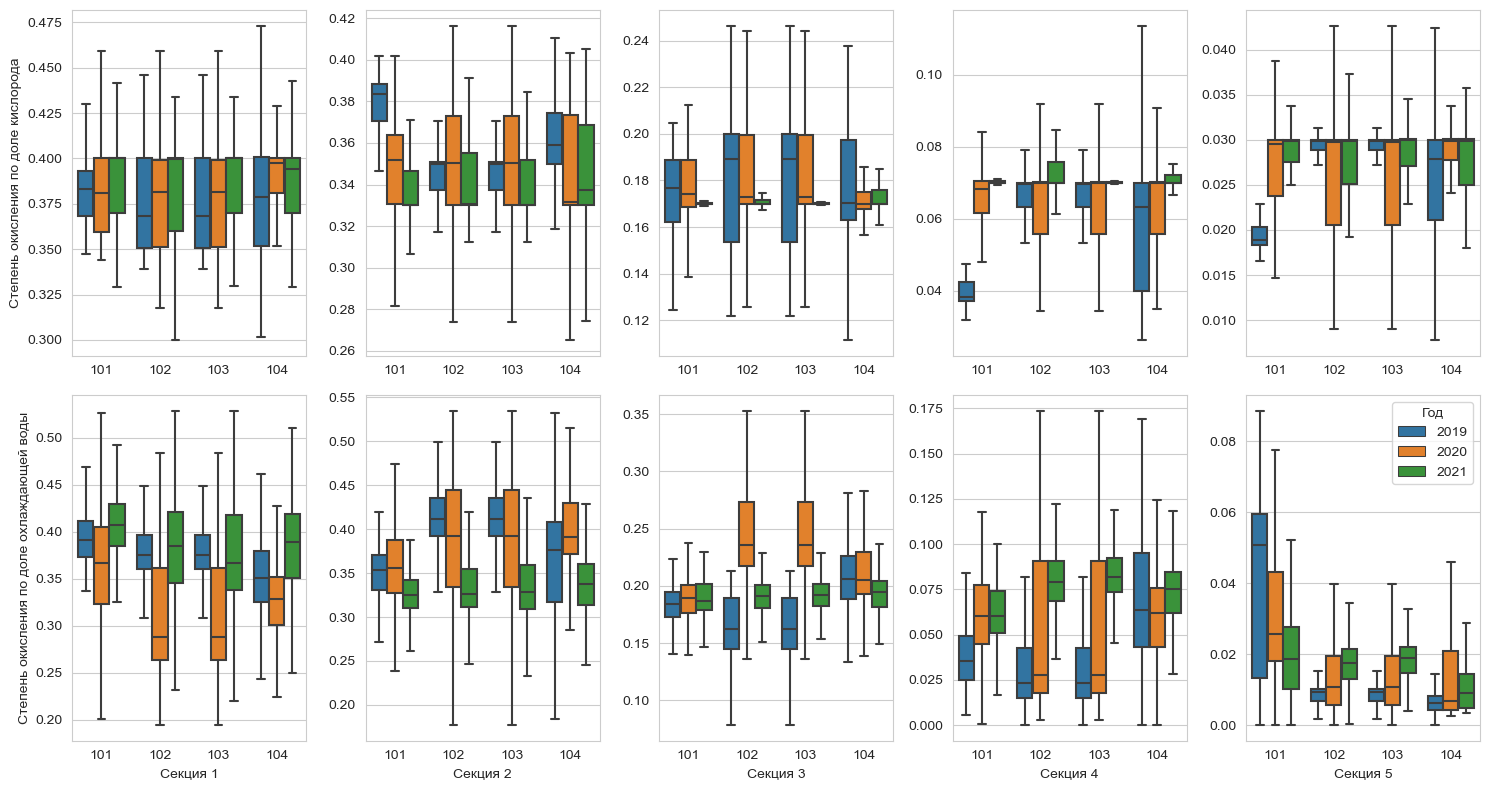

In [85]:
fig, ax = plt.subplots(2, 5, figsize=(15, 8))

betta_O = ['BettaS_O2_1', 'BettaS_O2_2', 'BettaS_O2_3', 'BettaS_O2_4', 'BettaS_O2_5']
betta_W = ['BettaS_QW_1', 'BettaS_QW_2', 'BettaS_QW_3', 'BettaS_QW_4', 'BettaS_QW_5']

for i, betta in enumerate(betta_O):
    sns.boxplot(data=df, y=betta, x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=ax[0, i])
    ax[0, i].set_ylabel("")
    ax[0, i].set_xlabel("")
    ax[0, i].legend([],[], frameon=False)

for i, betta in enumerate(betta_W):
    sns.boxplot(data=df, y=betta, x='ac', hue=df.index.year, whis=1.5, showfliers=False, ax=ax[1, i])
    ax[1, i].set_ylabel("")
    ax[1, i].set_xlabel("")
    ax[1, i].legend([],[], frameon=False)

ax[0, 0].set_ylabel("Степень окисления по доле кислорода")
ax[1, 0].set_ylabel("Степень окисления по доле охлаждающей воды")

ax[1, 4].legend(title="Год")

for i in range(5):
    ax[1, i].set_xlabel(f"Секция {i + 1}")

fig.tight_layout()
plt.show()